In [158]:
import os

import numpy as np
import pandas as pd
import pickle 
from tqdm import tqdm

from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

#keras
from keras import LSTM

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError


# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum
# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline

import logging
logging.raiseExceptions = False
import datetime

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

ImportError: cannot import name 'LSTM' from 'keras' (C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\__init__.py)

## Dataset general preparation

In [5]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df = df.set_index(["case", "t_point"])
df = df.sort_values(["case", "t_point"])
dynamic_idx = list(range(29, 42))
dynamic_columns = list(df.columns[dynamic_idx])
df.loc[:, dynamic_columns]
full_df = df.copy()
full_df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Exclude columns, which give information about how long the treatment was performed and about result

In [6]:
df = df.drop(["end_epizode", "admission_date", "current_process_duration", "process_stages", "outcome_tar", "long_observation_tar"], axis=1)

In [7]:
df.loc[df.index.levels[0][1]]

,омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact,age_stat_fact,трансфузия_dinam_control,оксигенотерапия_dinam_control,НИВЛ_dinam_control,ИВЛ_dinam_control
t_point,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,1.21,20.7,55.0,22.0,7.8,8.1,0.201,24.1,0,1,189.0,17.7,73,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,NaN,2.09,21.0,72.0,18.0,8.8,7.0,0.204,33.2,0,5,NaN,19.8,73,0,0,0,0


Проверим, менялись ли процедуры или нет за время лечения пациентов. Если вектор не менялся, мы можем использовать статичный вектор при предсказании

In [8]:
t = df.groupby(level=0).nunique().iloc[:, 42:]
pd.DataFrame(t.value_counts())

0
age_stat_fact трансфузия_dinam_control оксигенотерапия_dinam_control НИВЛ_dinam_control ИВЛ_dinam_control      
1             1                        1                             1                  1                  1619
                                       2                             1                  1                   184
                                       1                             1                  2                    61
              2                        1                             1                  2                    34
                                                                                        1                    30
              1                        1                             2                  2                    12
              2                        1                             2                  2                    10
              1                        2                             1                  2                     9
                                       1                             2                  1                     8
              2                        2                             1                  1                     6
                                                                                        2                     6
                                       1                             2                  1                     5
              1                        2                             2                  1                     3
              2                        2                             2                  2                     3
              1                        2                             2                  2                     2

Процедуры менялись. Проверим, что лекарства не менялись во время лечения пациентов

In [9]:
t = df.groupby(level=0).nunique().iloc[:, :29]
pd.DataFrame(t.value_counts())

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
омепразол_stat_control,надропарин кальция_stat_control,эзомепразол_stat_control,амлодипин_stat_control,амброксол_stat_control,домперидон_stat_control,меброфенин_stat_control,технеций_stat_control,мометазон_stat_control,бисопролол_stat_control,дексаметазон_stat_control,гидрохлоротиазид_stat_control,гидроксихлорохин_stat_control,рабепразол_stat_control,эноксапарин натрия_stat_control,периндоприл_stat_control,ацетилцистеин_stat_control,азитромицин_stat_control,валсартан_stat_control,метилпреднизолон_stat_control,лоратадин_stat_control,хлорохин_stat_control,натрия хлорид_stat_control,индапамид_stat_control,преднизолон_stat_control,аторвастатин_stat_control,декстран_stat_control,лизиноприл_stat_control,лозартан_stat_control,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1992


По лекарствам у всех пациентов набор препаратов не менялся, а по процедурам у 380 пациентов изменялся порядок.

Уберем всех пациентов лечившихся меньше 1 недели - они не дадут информации о развити заболевания


In [10]:
s = df.groupby(level=0).size()
df = df.loc[s[s>1].index.values]

Получили датасет для работы

In [11]:
df

омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                        

Разберем отдельно параметры

### Лимфоциты
Исследуем зависимость параметров Лимфоциты# и Лимфоциты%. Проанализируем их

Text(0.5, 1.0, 'Зависимость распределения \n Лимфоциты% от Лимфоциты#')

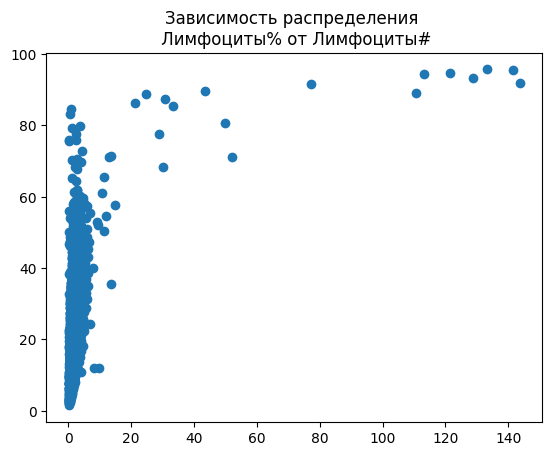

In [10]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
plt.scatter(data[:,0], data[:, 1])
plt.title("Зависимость распределения \n Лимфоциты% от Лимфоциты#")

Text(0.5, 1.0, 'Распределение величины Лимфоциты#_dinam_fact')

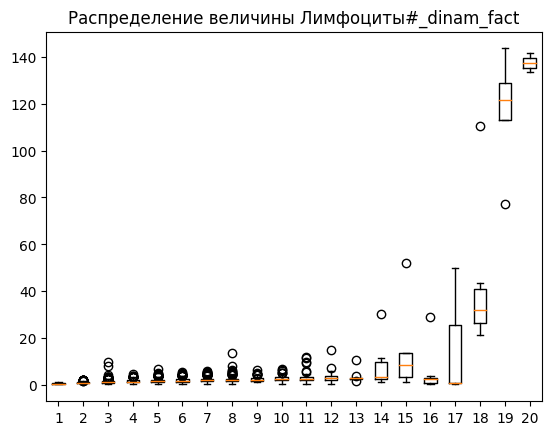

In [11]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты%_dinam_fact"]>i) & (df["Лимфоциты%_dinam_fact"]<i+5)]["Лимфоциты#_dinam_fact"] for i in range(0, 100, 5)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты#_dinam_fact")

Text(0.5, 1.0, 'Распределение величины Лимфоциты%_dinam_fact')

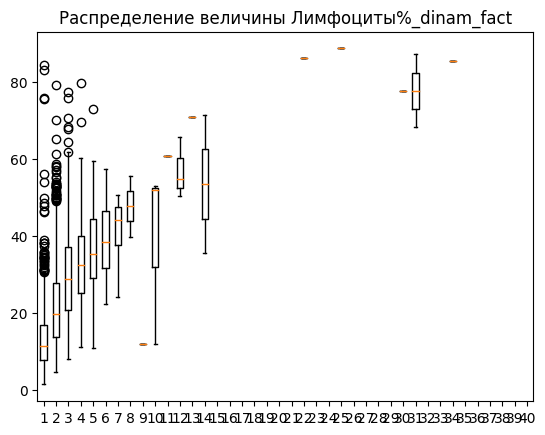

In [12]:
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = [df[(df["Лимфоциты#_dinam_fact"]>i) & (df["Лимфоциты#_dinam_fact"]<i+1)]["Лимфоциты%_dinam_fact"] for i in range(0, 40, 1)]
plt.boxplot(data)
plt.title("Распределение величины Лимфоциты%_dinam_fact")

Получается, что чистой корреляции у них нет. Однако чем выше количество лимфоцитов, тем больше их часть среди других лейкоцитов. Корреляцию Пирсона получаем 0.35 (P < 1e-159)

In [13]:
from scipy.stats import pearsonr
data = df[["Лимфоциты#_dinam_fact", "Лимфоциты%_dinam_fact"]].to_numpy()
data = data[~np.isnan(data[:, 0]) & ~np.isnan(data[:, 1]) , :]
pearsonr(data[:, 0], data[:, 1])

PearsonRResult(statistic=0.35366027434981473, pvalue=5.609278436072053e-159)

Получили, что зависимость есть, но она не линейная, так что нужно оставить оба параметра

### Степень тяжести по КТ 


In [17]:
df["Cтепень тяжести по КТ_dinam_fact"].reset_index()["Cтепень тяжести по КТ_dinam_fact"].value_counts()

5    3242
2    1248
1     730
3     693
4     194
0      28
Name: Cтепень тяжести по КТ_dinam_fact, dtype: int64

Не особо понятно что такое 0 степень тяжести, такая степень 28 раз встречается. 5 - самая распространенная

Параметр является мультиклассовым, можно использовать как классификацию, так и регрессию, так как в какой то степени есть порядковый смысл между переменными

### Снижение сознания

In [18]:
df["снижение_сознания_dinam_fact"].reset_index()["снижение_сознания_dinam_fact"].value_counts()

0    5780
2     354
1       1
Name: снижение_сознания_dinam_fact, dtype: int64

Спокойно можно удалить 1, так как существует одна запись, и заменить 2 на 1. Также возможно использовать вероятности снижения сознания

## Распределения параметров

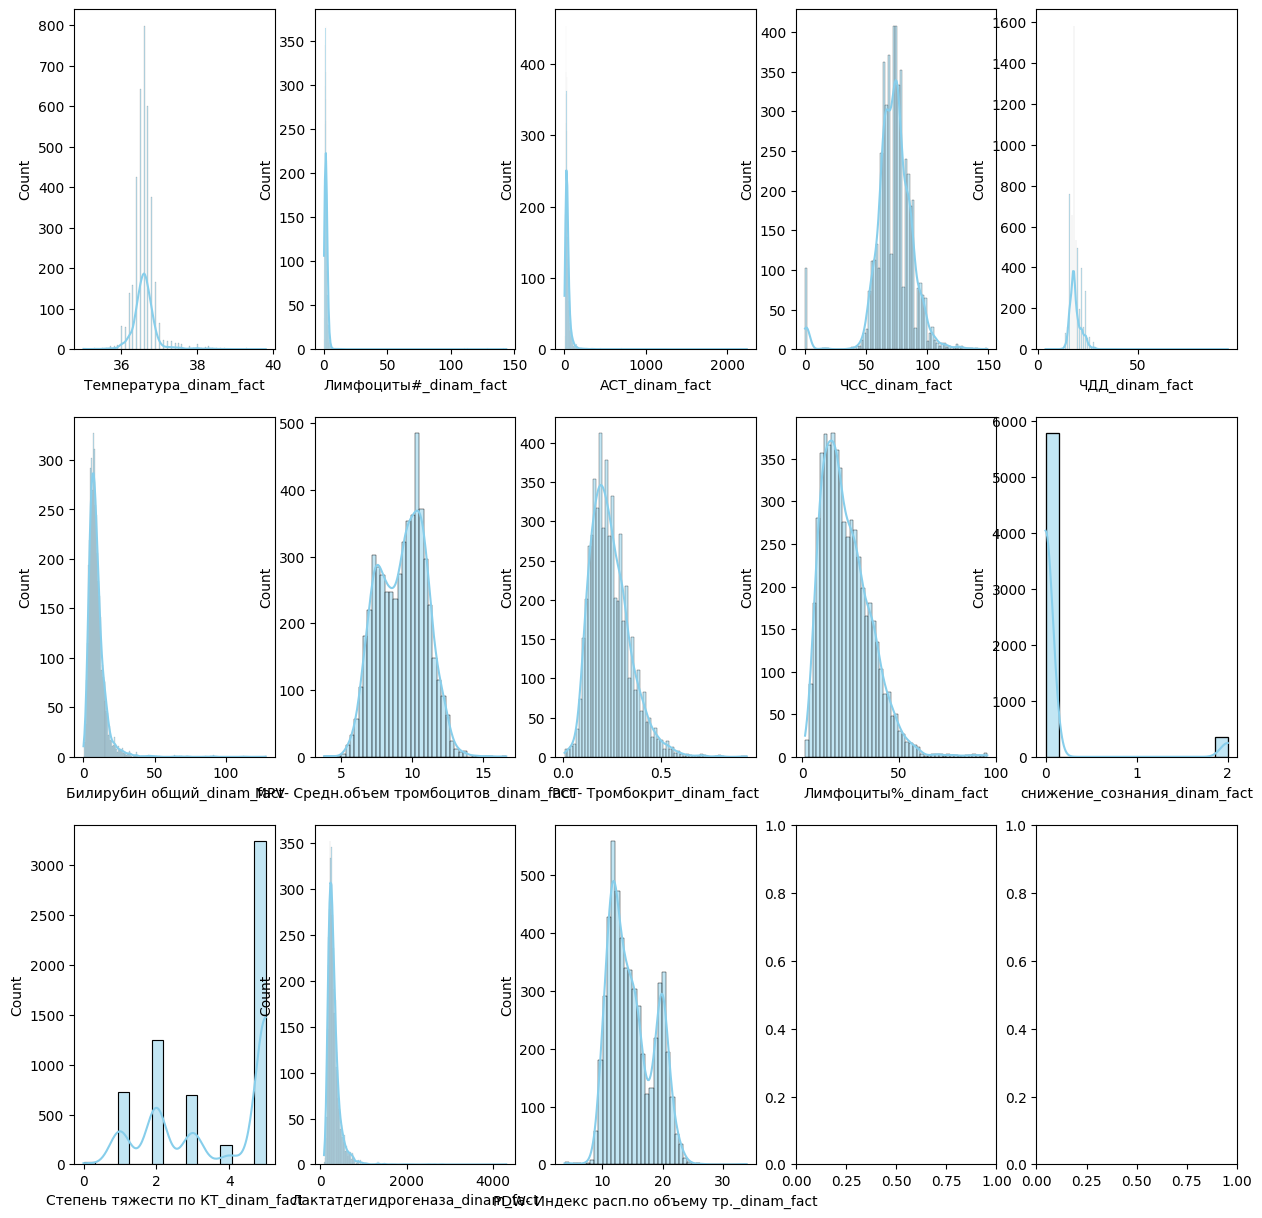

In [14]:
import seaborn as sns
figure, ax = plt.subplots(3, 5, figsize=(15, 15))
for i in range(13):
    sns.histplot(df.iloc[:, 29+i], color="skyblue", kde=True, ax=ax[i//5, i%5])

## Обучение

Теперь разделим датасет на окна - одна запись как фича, следующая за ней как таргет. И среди всех записей пациента проведем такую операцию

Выберем значения таргета без nan, и каждому из 13-ти параметров соотнесем пары - вектор параметров X и значение Y параметра на следующей неделе. 

In [71]:
def get_windows(df, window_size=2):
    X , y = [], []
    for i in df.index.levels[0]:
        try:
            for j in range(df.loc[i].index.size - window_size + 1):
                try:
                    X.append(df.loc[(i, j):(i, j+window_size-1)])
                    y.append(df.loc[(i, j+window_size)].iloc[29:42])
                except:
                    pass
        except:
            pass
    X, y = np.array(X), np.array(y)
    data = {param: [] for param in dynamic_columns}

    for i in range(len(data)):
        X_temp, y_temp = [], []
        for j in range(y.shape[0]):
            if not np.isnan(y[j][i]):
                X_temp.append(X[j])
                y_temp.append(y[j][i])
        data[dynamic_columns[i]] = {"X": np.array(X_temp), "y": np.array(y_temp)}

    return data
data = get_windows(df, 2)

In [72]:
data['Лимфоциты#_dinam_fact']["X"][3]

array([[1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 3.79e+01,
        7.30e-01, 2.76e+01, 6.10e+01, 2.50e+01, 5.00e+00, 1.07e+01,
        1.90e-01, 9.70e+00, 0.00e+00, 1.00e+00, 2.55e+02, 1.18e+01,
        5.90e+01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00],
       [1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 3.62e+01,
        2.04e+00,      nan, 8.40e+01, 2.00e+01,      nan, 1.03e+01,
        3.60e-01, 1.76e+01, 0.00e+00, 5.00e+00,      nan,

In [73]:
data['Лимфоциты#_dinam_fact']["y"][0]

2.13

Теперь посмотрим, сколько пар для обучения у нас присутствует

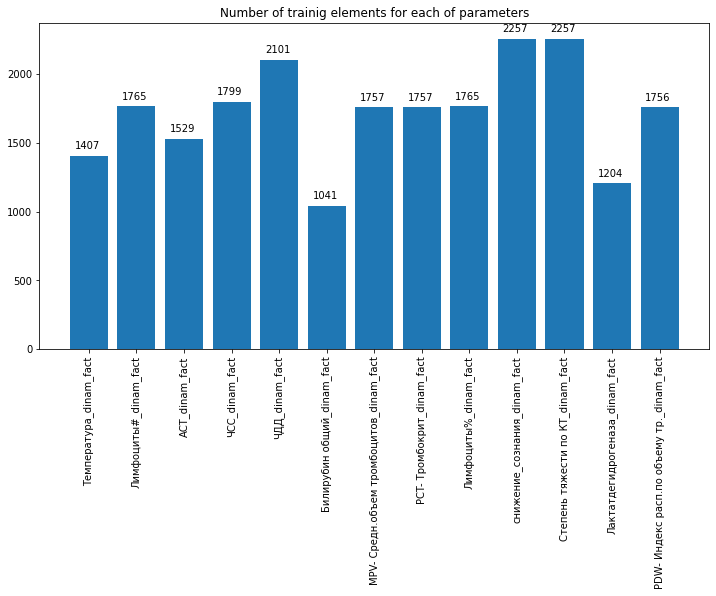

In [74]:
def get_samples_for_parameters(data):
  stat_nan = {k:len(data[k]["X"]) for k in data}
  l = stat_nan.keys()
  h = stat_nan.values()
  plt.figure(figsize=(12, 6))
  plt.bar(x=l, height=h)
  plt.xticks(rotation=90)
  plt.title("Number of trainig elements for each of parameters")
  for key_idx, key in enumerate(stat_nan):
    plt.text(key_idx-0.3,stat_nan[key]+50,stat_nan[key])

get_samples_for_parameters(data)

Нам важно измерить качество регрессии. Будем вычислять R2, MSE, mAPE и 95% интервалы этих метрик. Для доверительных интервалов будем использовать значения метрик модели на 5 фолдах (иными словами кросс валидацию) https://www.codecamp.ru/blog/confidence-intervals-python/

In [147]:
import scipy.stats as st

# Calculate R2, MSE, MAPE
def get_scores(y_real, y_pred):
    scores = {}
    scores["r2"] = r2_score(y_real, y_pred, multioutput="raw_values")
    scores["mse"] = mean_squared_error(y_real, y_pred, multioutput="raw_values")
    scores["mape"] = mean_absolute_percentage_error(y_real, y_pred, multioutput="raw_values")
    return scores

# Here we use composed pipeline to cross-validate it. I use 5-fold cross validation
def evaluate_with_intervals(model, X=None, y=None, folds=5, fedot=False):
    scoring_results = {"r2":[], "mape":[], "mse":[]}
    kf = KFold(folds)
    k = 0
    if (fedot):
        for train, test in kf.split(X, y): 
            indata_train = InputData(idx=np.arange(0, X[train].shape[0]), 
              features=X[train],
              target=y[train],
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            model.unfit()
            model.fit(indata_train)
            indata_test = InputData(idx=np.arange(0, X[test].shape[0]), 
              features=pd.DataFrame(X[test]),
              data_type=DataTypesEnum.table,
              task=Task(TaskTypesEnum.regression))
            y_pred = model.predict(indata_test).predict
            validation_data = get_scores(y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    else:
        for train, test in kf.split(X, y):
            model.fit(X[train], y[train])
            y_pred = model.predict(X[test])
            validation_data = get_scores( y[test], y_pred)
            for sc in scoring_results:
                scoring_results[sc].append(validation_data[sc])
            k+=1
    metrics_dataframe = {}
    for metric in scoring_results:
        scoring_result = scoring_results[metric]
        interval = st.t.interval(confidence=0.95 , df=len(scoring_result), loc=np.mean(scoring_result), scale=st.sem(scoring_result)) #95% interval
        metrics_dataframe["right_"+metric] = min(1, interval[1][0])
        metrics_dataframe["left_"+metric] = interval[0][0]
        metrics_dataframe["mean_"+metric] = ((interval[1]+interval[0])/2)[0]
    return metrics_dataframe



Чтобы обьективно понимать, что будущие модели будут улавливать закономерности а не рандомно делать свои ответы, попробуем возвращать только среднее значение параметра по всем возможным наблюдениям и после сравним эффективность такого подхода с моделью машинного обучения

### Удаление NaN

Для моделей необходимо убрать пропущенные значения. Воспользуемся простой вставкой среднего значения и IterativeImputer

In [95]:
from sklearn.linear_model import LinearRegression

class LinearRegressionClass():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data
    
    def train(self, df, window=2):
        data = self.preprocess(df, window)
        models = {}
        for i, column in enumerate(data.keys()):
            X_vec = data[column]["X"]
            y_vec = data[column]["y"]
            models[column] = self.model.fit(X_vec, y_vec)
        return models
    
lrclass = LinearRegressionClass()
models = lrclass.train(df, 2)
models

{'Температура_dinam_fact': LinearRegression(),
 'Лимфоциты#_dinam_fact': LinearRegression(),
 'АСТ_dinam_fact': LinearRegression(),
 'ЧСС_dinam_fact': LinearRegression(),
 'ЧДД_dinam_fact': LinearRegression(),
 'Билирубин общий_dinam_fact': LinearRegression(),
 'MPV- Средн.объем тромбоцитов_dinam_fact': LinearRegression(),
 'PCT- Тромбокрит_dinam_fact': LinearRegression(),
 'Лимфоциты%_dinam_fact': LinearRegression(),
 'снижение_сознания_dinam_fact': LinearRegression(),
 'Cтепень тяжести по КТ_dinam_fact': LinearRegression(),
 'Лактатдегидрогеназа_dinam_fact': LinearRegression(),
 'PDW- Индекс расп.по объему тр._dinam_fact': LinearRegression()}

# Train models

Result_table - таблица с нашими метриками моделей

In [155]:
result_table = pd.DataFrame()

### LinearRegression

In [152]:
from sklearn.linear_model import LinearRegression

class LinearRegressionClass():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].reshape(-1, 47*window)
        return data
    
    def train(self, df, window=2):
        data = self.preprocess(df, window)
        models = {}
        for i, column in enumerate(data.keys()):
            X_vec = data[column]["X"]
            y_vec = data[column]["y"]
            models[column] = self.model.fit(X_vec, y_vec)
        return models
    
class LinearRegressionClassMean():
    def __init__(self):
        self.scaler = StandardScaler()
        self.imputer=IterativeImputer(max_iter=50)
        self.model = LinearRegression()

    def preprocess(self, df, window=2):
        df_preprocessed = df.copy()
        self.scaler.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.scaler.transform(df_preprocessed.iloc[:, 29:43])
        self.imputer.fit(df_preprocessed.iloc[:, 29:43])
        df_preprocessed.iloc[:, 29:43] = self.imputer.transform(df_preprocessed.iloc[:, 29:43])
        data = get_windows(df_preprocessed, window)
        for i, column in enumerate(data.keys()):
            data[column]["X"] = data[column]["X"].mean(axis=1)
        return data
    
    def train(self, df, window=2):
        data = self.preprocess(df, window)
        models = {}
        for i, column in enumerate(data.keys()):
            X_vec = data[column]["X"]
            y_vec = data[column]["y"]
            models[column] = self.model.fit(X_vec, y_vec)
        return models
    
lrclass = LinearRegressionClassMean()
models = lrclass.train(df, 2)
lrclass = LinearRegressionClass()
models = lrclass.train(df, 2)

{'Температура_dinam_fact': LinearRegression(),
 'Лимфоциты#_dinam_fact': LinearRegression(),
 'АСТ_dinam_fact': LinearRegression(),
 'ЧСС_dinam_fact': LinearRegression(),
 'ЧДД_dinam_fact': LinearRegression(),
 'Билирубин общий_dinam_fact': LinearRegression(),
 'MPV- Средн.объем тромбоцитов_dinam_fact': LinearRegression(),
 'PCT- Тромбокрит_dinam_fact': LinearRegression(),
 'Лимфоциты%_dinam_fact': LinearRegression(),
 'снижение_сознания_dinam_fact': LinearRegression(),
 'Cтепень тяжести по КТ_dinam_fact': LinearRegression(),
 'Лактатдегидрогеназа_dinam_fact': LinearRegression(),
 'PDW- Индекс расп.по объему тр._dinam_fact': LinearRegression()}

In [153]:
from sklearn.linear_model import LinearRegression

parameters_validation = []
lrclass = LinearRegressionClassMean()
for window in [1, 2, 3, 4, 5]: 
    data = lrclass.preprocess(df, window)
    for column in tqdm(list(data.keys())):
        X_param, y_param = data[column]["X"], data[column]["y"]
        model = LinearRegression()
        metrs = evaluate_with_intervals(model, X_param, y_param) 
        metrs["parameter"] = column
        metrs["model"] = "LinearRegression with Mean"
        metrs["window"] = window
        parameters_validation.append(metrs)
    result_table = pd.concat([result_table, pd.DataFrame(parameters_validation)])
    result_table.to_csv("")
pd.DataFrame(parameters_validation)

100%|██████████| 13/13 [00:00<00:00, 24.17it/s]


,right_r2,left_r2,mean_r2,right_mape,left_mape,mean_mape,right_mse,left_mse,mean_mse,parameter,model,window
0,0.013630,-0.104647,-0.045509,1.000000,1.481854,3.517660,0.559856,0.153333,0.356594,Температура_dinam_fact,LinearRegression,1
1,-0.063517,-1.665883,-0.864700,1.000000,4.054923,8.625593,1.000000,-1.495677,1.140406,Лимфоциты#_dinam_fact,LinearRegression,1
2,-0.011415,-0.031441,-0.021428,1.000000,1.403333,3.923661,1.000000,0.364990,1.181261,АСТ_dinam_fact,LinearRegression,1
3,-0.023621,-0.031447,-0.027534,1.000000,1.364034,1.734248,1.000000,0.654553,0.831977,ЧСС_dinam_fact,LinearRegression,1
4,-0.010883,-0.043887,-0.027385,1.000000,10.353300,11.325859,0.585334,0.243687,0.414510,ЧДД_dinam_fact,LinearRegression,1
5,-0.001886,-0.091301,-0.046593,1.000000,1.354016,2.998237,1.000000,0.397253,0.770409,Билирубин общий_dinam_fact,LinearRegression,1
6,0.015630,-0.385979,-0.185174,1.000000,1.986478,2.521539,1.000000,0.842503,0.964838,MPV- Средн.объем тромбоцитов_dinam_fact,LinearRegression,1
7,-0.021598,-0.069135,-0.045366,1.000000,-7.492230,7.361980,1.000000,0.884464,0.954360,PCT- Тромбокрит_dinam_fact,LinearRegression,1
8,-0.009255,-0.196921,-0.103088,1.000000,0.423394,2.264527,1.000000,0.808247,0.969632,Лимфоциты%_dinam_fact,LinearRegression,1
9,-0.011659,-0.125224,-0.068441,1.000000,0.830340,1.068297,1.000000,0.608360,1.079903,снижение_сознания_dinam_fact,LinearRegression,1


### RNN

In [157]:
from keras import LSTM

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError

model = 

ImportError: cannot import name 'LSTM' from 'keras' (C:\Users\sirau\AppData\Roaming\Python\Python310\site-packages\keras\__init__.py)

### HistGradientBoostingRegressor

Сделаем модели на каждый параметр с простенькой моделью HistGradientBoostingRegressor (она единственная из sklearn ргегрессоров поддерживает NaN)

In [198]:


parameters_validation = []
for column in tqdm(list(data.keys())):
    X_param, y_param = data[column]["X"], data[column]["y"]
    model = HistGradientBoostingRegressor()
    metrs = evaluate_with_intervals(model, X_param, y_param) 
    metrs["parameter"] = column
    metrs["model"] = "HistGradientBoostingRegressor"
    parameters_validation.append(metrs)

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed Температура_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed Лимфоциты#_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed АСТ_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed ЧСС_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Model fitted on fold 4 / 5
Successfully processed ЧДД_dinam_fact 

Model fitted on fold 0 / 5
Model fitted on fold 1 / 5
Model fitted on fold 2 / 5
Model fitted on fold 3 / 5
Mo

In [199]:
pd.concat(parameters_validation)

,max_r2,min_r2,avg_r2,max_mape,min_mape,avg_mape,max_mse,min_mse,avg_mse,parameter,model
0,-0.069213,-0.206247,-0.137730,5.577604e-03,4.695341e-03,5.136472e-03,0.089643,0.061523,0.075583,Температура_dinam_fact,HistGradientBoostingRegressor
0,0.975189,-0.659533,0.157828,4.556526e-01,3.734947e-01,4.145737e-01,14.139650,-4.487169,4.826240,Лимфоциты#_dinam_fact,HistGradientBoostingRegressor
0,0.626716,-1.712989,-0.543137,1.151331e+00,4.183200e-01,7.848253e-01,12100.562694,5889.099611,8994.831152,АСТ_dinam_fact,HistGradientBoostingRegressor
0,-0.068322,-0.121367,-0.094844,2.577899e+00,8.460319e-01,1.711966e+00,350.373914,215.986328,283.180121,ЧСС_dinam_fact,HistGradientBoostingRegressor
0,0.059771,-0.003266,0.028252,8.427894e-02,7.089102e-02,7.758498e-02,8.279868,2.876714,5.578291,ЧДД_dinam_fact,HistGradientBoostingRegressor
0,0.390767,0.218667,0.304717,5.185060e-01,3.735674e-01,4.460367e-01,60.172151,19.063624,39.617888,Билирубин общий_dinam_fact,HistGradientBoostingRegressor
0,0.900819,0.413710,0.657265,1.072134e-01,4.506701e-02,7.614020e-02,1.507406,0.286075,0.896740,MPV- Средн.объем тромбоцитов_dinam_fact,HistGradientBoostingRegressor
0,0.366069,0.228749,0.297409,3.646570e-01,2.775051e-01,3.210811e-01,0.008953,0.006417,0.007685,PCT- Тромбокрит_dinam_fact,HistGradientBoostingRegressor
0,0.407624,0.324771,0.366198,4.845369e-01,4.255743e-01,4.550556e-01,112.864122,81.193142,97.028632,Лимфоциты%_dinam_fact,HistGradientBoostingRegressor
0,0.968874,0.876736,0.922805,1.225776e+14,5.740608e+13,8.999185e+13,0.027148,0.006839,0.016993,снижение_сознания_dinam_fact,HistGradientBoostingRegressor


### Fedot

Построим пайплайны с помощью Fedot на каждый из параметров. 

Будем использовать таймаут 10 минут, так как при дальнейшем продолжении композиции качество не увеличивается на все параметрах

In [ ]:
# #takes a long time (about 2 hours), be careful!
# for col in list(data.keys()):
#     print(f"Start composing {col}")
#     model = Fedot(problem="regression", timeout=10, cache_folder="D:\\Cache") # I changed cache folder path as it tkaes up to 20Gb
#     X_param, y_param = data[col]["X"], data[col]["y"]
#     pipeline = model.fit(X_param, y_param)
#     pipeline.save(f"fedot_pipelines\\{col}", create_subdir=False, is_datetime_in_path=False)
#     print(f"Successfully composed {col} \n")

И построенные пайплайны с тюнеными параметрами оцениваем кросс-валидацией на тех же данных, что и строили


In [ ]:
obtained_pipelines = []
metrics_saved = []
for col in list(data.keys()):
    print(f"Start fitting model for {col}")
    model = Fedot(problem="regression", timeout=1) 
    X_param, y_param = data[col]["X"], data[col]["y"]
    pipeline = model.fit(X_param, y_param)
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrs = evaluate_with_intervals(pipeline, X_param, y_param, folds=5, fedot=True) # fedot=True for InputData using instead of direct parameters
    metrs["parameter"] = col
    metrs["model"] = "Fedot"
    metrics_saved.append(metrs)
    print(f"Successfully processed {col} \n")

In [29]:
pd.concat(metrics_saved)

,max_r2,min_r2,avg_r2,max_mape,min_mape,avg_mape,max_mse,min_mse,avg_mse,parameter,model
0,0.014704,-0.027938,-0.006617,5.111347e-03,4.257511e-03,4.684429e-03,0.080361,0.052652,0.066506,Температура_dinam_fact,Fedot
0,0.745285,-0.131912,0.306686,4.485773e-01,3.669376e-01,4.077574e-01,96.076242,-40.980501,27.547871,Лимфоциты#_dinam_fact,Fedot
0,0.185792,-0.135471,0.025161,9.337671e-01,5.033833e-01,7.185752e-01,10992.431099,2521.537391,6756.984245,АСТ_dinam_fact,Fedot
0,0.036800,-0.007413,0.014693,2.394083e+00,9.071429e-01,1.650613e+00,312.226694,199.198987,255.712840,ЧСС_dinam_fact,Fedot
0,0.133211,0.060169,0.096690,7.850307e-02,6.672943e-02,7.261625e-02,7.997469,2.395779,5.196624,ЧДД_dinam_fact,Fedot
0,0.566675,0.236796,0.401735,5.357832e-01,3.402495e-01,4.380163e-01,50.631168,14.726126,32.678647,Билирубин общий_dinam_fact,Fedot
0,0.891258,0.441420,0.666339,1.048808e-01,4.480286e-02,7.484185e-02,1.417657,0.320066,0.868861,MPV- Средн.объем тромбоцитов_dinam_fact,Fedot
0,0.379866,0.237794,0.308830,3.737732e-01,2.877667e-01,3.307699e-01,0.008871,0.006341,0.007606,PCT- Тромбокрит_dinam_fact,Fedot
0,0.433300,0.341185,0.387242,4.932057e-01,4.256187e-01,4.594122e-01,112.188877,83.091658,97.640267,Лимфоциты%_dinam_fact,Fedot
0,0.979057,0.882812,0.930934,5.644414e+13,2.225635e+13,3.935024e+13,0.025954,0.004904,0.015429,снижение_сознания_dinam_fact,Fedot


In [32]:
resultdf = pd.concat(metrics_saved)
resultdf.to_csv("Fedot_metrics.csv")

## Window length 2

In [57]:
X, y = [], []
for i in df.index.levels[0]:
    try:
        for j in range(df.loc[i].index.size - 2):
            try:
                X.append(df.loc[(i, j): (i, j+1)])
                y.append(df.loc[(i, j+2)].iloc[29:42])
            except:
                pass
    except:
        pass
X, y = np.array(X).reshape(-1, 2*47), np.array(y)

In [58]:
data = {param: [] for param in dynamic_columns}
for i in range(len(data)):
    X_temp, y_temp = [], []
    for j in range(y.shape[0]):
        if not np.isnan(y[j][i]):
            X_temp.append(X[j])
            y_temp.append(y[j][i])
    data[dynamic_columns[i]] = {"X": np.array(X_temp), "y": np.array(y_temp)}

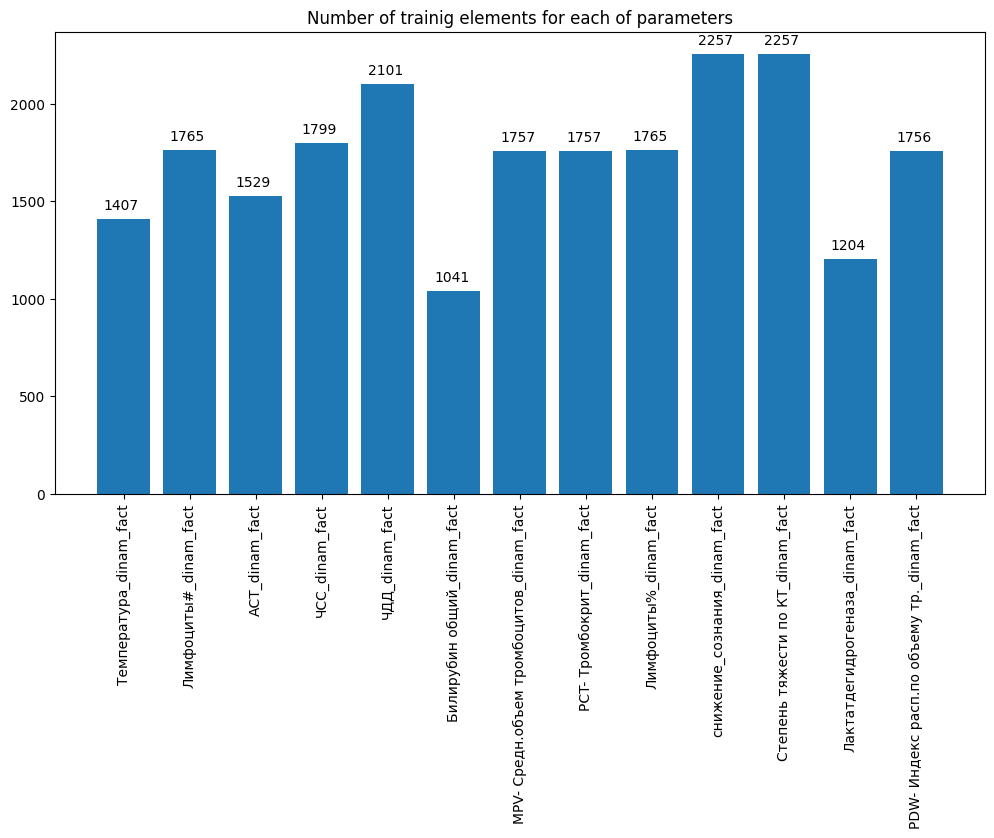

In [59]:
stat_nan = {k:len(data[k]["X"]) for k in data}
l = stat_nan.keys()
h = stat_nan.values()
plt.figure(figsize=(12, 6))
plt.bar(x=l, height=h)
plt.xticks(rotation=90)
plt.title("Number of trainig elements for each of parameters")
for key_idx, key in enumerate(stat_nan):
  plt.text(key_idx-0.3,stat_nan[key]+50,stat_nan[key])

In [ ]:
obtained_pipelines = []
metrics_saved = []
for col in list(data.keys()):
    print(f"Start fitting model for {col}")
    model = Fedot(problem="regression", timeout=1) 
    X_param, y_param = data[col]["X"], data[col]["y"]
    pipeline = model.fit(X_param, y_param)
    pipeline.save(f"fedot_pipelines_w2\\{col}", create_subdir=False, is_datetime_in_path=False)
    X_param, y_param = data[col]["X"], data[col]["y"]
    metrs = evaluate_with_intervals(pipeline, X_param, y_param, folds=5, fedot=True) # fedot=True for InputData using instead of direct parameters
    metrs["parameter"] = col
    metrs["model"] = "Fedot"
    metrics_saved.append(metrs)
    print(f"Successfully processed {col} \n")

In [61]:
resultdf = pd.concat(metrics_saved)
resultdf.to_csv("Fedot_metrics_wind2.csv")

In [62]:
resultdf

,max_r2,min_r2,avg_r2,max_mape,min_mape,avg_mape,max_mse,min_mse,avg_mse,parameter,model
0,0.015104,-0.008076,0.003514,4.659811e-03,3.819397e-03,4.239604e-03,0.062786,0.042622,0.052704,Температура_dinam_fact,Fedot
0,0.857565,-0.069987,0.393789,4.367243e-01,3.400805e-01,3.884024e-01,101.472765,-43.602807,28.934979,Лимфоциты#_dinam_fact,Fedot
0,0.136612,-0.005667,0.065473,4.125009e-01,3.490338e-01,3.807673e-01,22940.574540,-2228.608585,10355.982978,АСТ_dinam_fact,Fedot
0,0.053627,-0.010997,0.021315,2.534022e+00,1.000271e+00,1.767147e+00,336.908139,206.188786,271.548463,ЧСС_dinam_fact,Fedot
0,0.200511,0.077903,0.139207,7.258464e-02,5.866103e-02,6.562283e-02,8.914666,0.148761,4.531714,ЧДД_dinam_fact,Fedot
0,0.628614,0.282944,0.455779,6.149174e-01,2.855455e-01,4.502315e-01,78.147065,13.943444,46.045255,Билирубин общий_dinam_fact,Fedot
0,0.902667,0.487967,0.695317,9.751198e-02,4.116217e-02,6.933708e-02,1.282142,0.236872,0.759507,MPV- Средн.объем тромбоцитов_dinam_fact,Fedot
0,0.459025,0.309326,0.384176,3.576354e-01,2.528123e-01,3.052238e-01,0.006717,0.004063,0.005390,PCT- Тромбокрит_dinam_fact,Fedot
0,0.553580,0.407050,0.480315,4.485686e-01,3.871657e-01,4.178672e-01,101.600035,69.146226,85.373130,Лимфоциты%_dinam_fact,Fedot
0,0.981578,0.762528,0.872053,2.139862e+13,-9.304218e+12,6.047200e+12,0.051310,0.007160,0.029235,снижение_сознания_dinam_fact,Fedot


In [64]:
from sklearn.ensemble import HistGradientBoostingRegressor

result_table = pd.DataFrame()
parameters_validation = []
for col in list(data.keys()):
    X_param, y_param = data[col]["X"], data[col]["y"]
    model = HistGradientBoostingRegressor()
    metrs = evaluate_with_intervals(model, X_param, y_param) 
    metrs["parameter"] = col
    metrs["model"] = "HistGradientBoostingRegressor"
    parameters_validation.append(metrs)
    print(f"Successfully processed {col} \n")

Successfully processed Температура_dinam_fact 

Successfully processed Лимфоциты#_dinam_fact 

Successfully processed АСТ_dinam_fact 

Successfully processed ЧСС_dinam_fact 

Successfully processed ЧДД_dinam_fact 

Successfully processed Билирубин общий_dinam_fact 

Successfully processed MPV- Средн.объем тромбоцитов_dinam_fact 

Successfully processed PCT- Тромбокрит_dinam_fact 

Successfully processed Лимфоциты%_dinam_fact 

Successfully processed снижение_сознания_dinam_fact 

Successfully processed Cтепень тяжести по КТ_dinam_fact 

Successfully processed Лактатдегидрогеназа_dinam_fact 

Successfully processed PDW- Индекс расп.по объему тр._dinam_fact 



In [67]:
resultdf = pd.concat(parameters_validation)
resultdf.to_csv("HistGradientBoosting_window2.csv")

In [122]:
import pandas as pd
fm = pd.read_csv("Fedot_metrics.csv", index_col=None)
fm2 = pd.read_csv("Fedot_metrics_wind2.csv")
hm = pd.read_csv("HistGradientBoosting_metrics.csv")
hm2 = pd.read_csv("HistGradientBoosting_metrics_window2.csv")
tdf = fm
tdf[["parameter", "min_r2", "max_r2", "avg_r2"]].set_index("parameter")

,min_r2,max_r2,avg_r2
parameter,,,
Температура_dinam_fact,-0.027938,0.014704,-0.006617
Лимфоциты#_dinam_fact,-0.131912,0.745285,0.306686
АСТ_dinam_fact,-0.135471,0.185792,0.025161
ЧСС_dinam_fact,-0.007413,0.036800,0.014693
ЧДД_dinam_fact,0.060169,0.133211,0.096690
Билирубин общий_dinam_fact,0.236796,0.566675,0.401735
MPV- Средн.объем тромбоцитов_dinam_fact,0.441420,0.891258,0.666339
PCT- Тромбокрит_dinam_fact,0.237794,0.379866,0.308830
Лимфоциты%_dinam_fact,0.341185,0.433300,0.387242


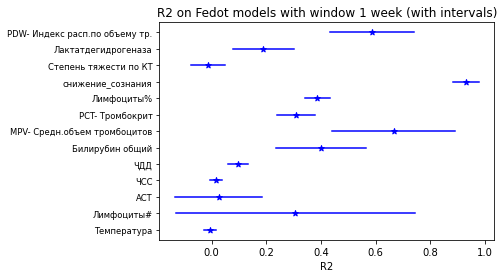

In [126]:
tdf = fm
pldata = tdf[["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")
plt.title("R2 on Fedot models with window 1 week (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.show()

In [127]:
tdf = hm
tdf[["parameter", "min_r2", "max_r2", "avg_r2"]].set_index("parameter")

,min_r2,max_r2,avg_r2
parameter,,,
Температура_dinam_fact,-0.218601,-0.045836,-0.132219
Лимфоциты#_dinam_fact,-1.531371,0.492502,-0.519435
АСТ_dinam_fact,-1.685202,0.639144,-0.523029
ЧСС_dinam_fact,-0.122738,-0.047643,-0.085191
ЧДД_dinam_fact,-0.037354,0.046806,0.004726
Билирубин общий_dinam_fact,0.172434,0.380121,0.276278
MPV- Средн.объем тромбоцитов_dinam_fact,0.415716,0.897573,0.656644
PCT- Тромбокрит_dinam_fact,0.216301,0.375780,0.296040
Лимфоциты%_dinam_fact,0.305103,0.474794,0.389948


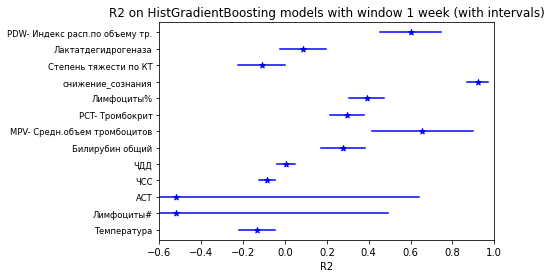

In [150]:
tdf = hm
import numpy as np
pldata = tdf[["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")
plt.title("R2 on HistGradientBoosting models with window 1 week (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.xlim((-0.6, 1))
plt.show()

In [134]:
tdf = hm2
tdf[["parameter", "min_r2", "max_r2", "avg_r2"]].set_index("parameter")
tdf.loc[tdf[tdf["max_r2"]>1].index, "max_r2"] = 1
tdf[["parameter", "min_r2", "max_r2", "avg_r2"]].set_index("parameter")

,min_r2,max_r2,avg_r2
parameter,,,
Температура_dinam_fact,-0.164567,-0.102006,-0.133286
Лимфоциты#_dinam_fact,-1.931608,0.726916,-0.602346
АСТ_dinam_fact,-8.340363,1.000000,-2.895814
ЧСС_dinam_fact,-0.115900,-0.042868,-0.079384
ЧДД_dinam_fact,-0.036888,0.123931,0.043521
Билирубин общий_dinam_fact,0.149049,0.505674,0.327361
MPV- Средн.объем тромбоцитов_dinam_fact,0.493816,0.881919,0.687867
PCT- Тромбокрит_dinam_fact,0.280609,0.433798,0.357204
Лимфоциты%_dinam_fact,0.336276,0.496436,0.416356


In [ ]:
tdf[tdf["max_r2"]>1]

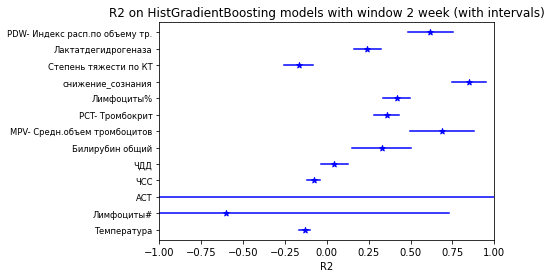

In [166]:
tdf = hm2
pldata = tdf[["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")
plt.title("R2 on HistGradientBoosting models with window 2 week (with intervals)")
plt.xlabel("R2")
plt.xlim((-1, 1))
plt.yticks(range(len(psnames)), psnames , size='small')
plt.show()

In [157]:
tdf = fm2
tdf[["parameter", "min_r2", "max_r2", "avg_r2"]].set_index("parameter")

,min_r2,max_r2,avg_r2
parameter,,,
Температура_dinam_fact,-0.008076,0.015104,0.003514
Лимфоциты#_dinam_fact,-0.069987,0.857565,0.393789
АСТ_dinam_fact,-0.005667,0.136612,0.065473
ЧСС_dinam_fact,-0.010997,0.053627,0.021315
ЧДД_dinam_fact,0.077903,0.200511,0.139207
Билирубин общий_dinam_fact,0.282944,0.628614,0.455779
MPV- Средн.объем тромбоцитов_dinam_fact,0.487967,0.902667,0.695317
PCT- Тромбокрит_dinam_fact,0.309326,0.459025,0.384176
Лимфоциты%_dinam_fact,0.407050,0.553580,0.480315


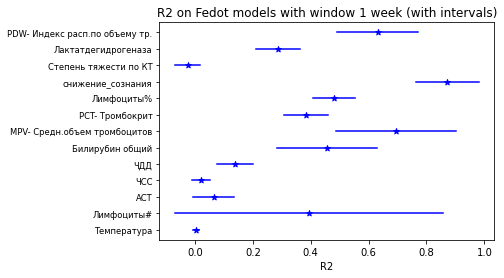

In [156]:
tdf = fm2
pldata = tdf[["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")
plt.title("R2 on Fedot models with window 2 week (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.show()

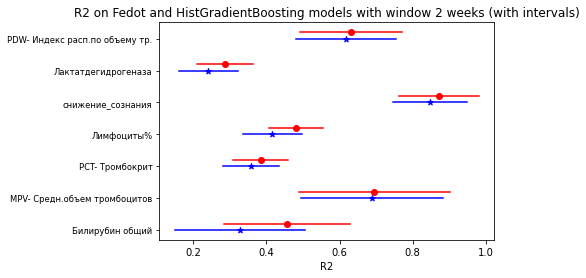

In [190]:
tdf = hm2
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")


tdf = fm2
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i+0.2, i+0.2], c="red")
    plt.scatter(pldata.iloc[i, 2], [i+0.2], c="red", marker="o")
plt.title("R2 on Fedot and HistGradientBoosting models with window 2 weeks (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.xlim()
plt.show()

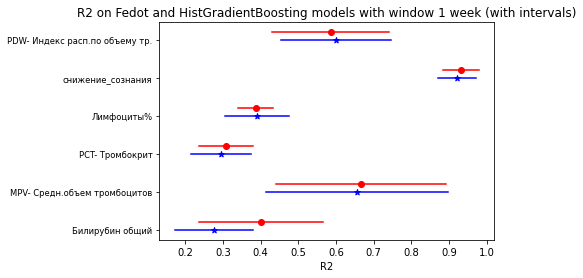

In [182]:
tdf = hm
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")


tdf = fm
pldata = tdf[(tdf["max_r2"]>0.1) & (tdf["min_r2"]>0.1)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i+0.2, i+0.2], c="red")
    plt.scatter(pldata.iloc[i, 2], [i+0.2], c="red", marker="o")
plt.title("R2 on Fedot and HistGradientBoosting models with window 1 week (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.xlim()
plt.show()

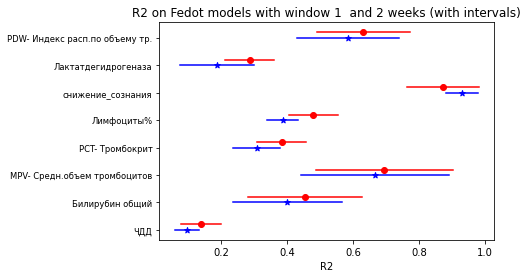

In [200]:
tdf = fm
pldata = tdf[(tdf["max_r2"]>0) & (tdf["min_r2"]>0)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i, i], c="blue")
    plt.scatter(pldata.iloc[i, 2], [i], c="blue", marker="*")


tdf = fm2
pldata = tdf[(tdf["max_r2"]>0) & (tdf["min_r2"]>0)][["max_r2", "min_r2", "avg_r2", "parameter", "model"]]
psnames = [i[:len(i)-11] for i in pldata["parameter"]]
for i in range(pldata.shape[0]):
    plt.plot(pldata.iloc[i, 0:2], [i+0.2, i+0.2], c="red")
    plt.scatter(pldata.iloc[i, 2], [i+0.2], c="red", marker="o")
plt.title("R2 on Fedot models with window 1  and 2 weeks (with intervals)")
plt.xlabel("R2")
plt.yticks(range(len(psnames)), psnames , size='small')
plt.xlim()
plt.show()

## RNN

## Готовая модель
Здесь мы берем вектор текущих значений и последовательно всеми моделями предсказываем параметры

In [109]:
df_test = None
with open("covid_flow.pkl", "rb") as f:
    df_test = pickle.load(f)
df_test["case"] = df_test.index
df_test["t_point"] = df_test["t_point"].apply(lambda x: x[2:])
df_test["t_point"] = df_test["t_point"].apply(lambda x: int(x))
df_test = df_test.set_index(["case", "t_point"])
df_test = df_test.sort_values(["case", "t_point"])
df_test = df_test.iloc[:, :-6]
df_test.to_csv("covid_flow_test.csv")

In [113]:
import os
models = os.listdir("fedot_pipelines")
res = {}
df_pred = pd.read_csv("covid_flow_test.csv")
state_vector = df_pred.groupby("case").last()

input_data = InputData(idx=state_vector.index, 
          features=state_vector, 
          data_type=DataTypesEnum.table,
          task=Task(TaskTypesEnum.regression)
         )

pipelines = {}
for model in models:
    pipeline = Pipeline()
    pipeline.load(f"fedot_pipelines_april/{model}/{model}.json")
    pipelines[model] = pipeline

prediction_vector = {}
for model in models:
    prediction_vector[model] = pipelines[model].predict(input_data).predict

# Categorical features
result = pd.DataFrame(prediction_vector)
result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))
result


C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:25: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "снижение_сознания_dinam_fact"] = result["снижение_сознания_dinam_fact"].apply(lambda x: int(x))
C:\Users\sirau\AppData\Local\Temp\ipykernel_18648\2315768102.py:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.loc[:, "Cтепень тяжести по КТ_dinam_fact"] = result["Cтепень тяжести по КТ_dinam_fact"].apply(lambda x: int(x))


,Cтепень тяжести по КТ_dinam_fact,MPV- Средн,PCT- Тромбокрит_dinam_fact,PDW- Индекс расп.по объему тр,АСТ_dinam_fact,Билирубин общий_dinam_fact,Лактатдегидрогеназа_dinam_fact,Лимфоциты#_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Температура_dinam_fact,ЧДД_dinam_fact,ЧСС_dinam_fact
0,4,10.484670,0.426379,19.989427,71.037622,27.893488,242.034955,31.4739,21.047,0,36.555054,18.285308,70.388403
1,4,9.076119,0.431977,19.508176,76.545647,23.449568,230.588356,27.4664,22.949,0,36.555054,18.538296,71.789489
2,4,7.908733,0.382579,19.166321,77.402444,26.216675,230.557088,27.1759,24.632,0,36.555054,18.691578,70.974182
3,4,11.642310,0.408423,19.752500,72.178914,27.321833,245.660825,29.7954,22.246,0,36.555054,18.184847,71.475092
4,4,8.095603,0.379879,19.216131,82.737148,29.964315,230.293717,28.7912,24.393,0,36.555054,18.444508,71.562158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,4,7.880028,0.382579,19.174636,76.942369,21.658008,230.081140,27.0265,24.480,0,36.555054,18.555603,71.640981
1988,4,8.072296,0.382579,19.245525,76.741001,33.056502,230.496630,27.0265,26.629,0,36.555054,18.938909,72.146455
1989,4,8.113531,0.386250,19.435683,79.932451,32.013713,233.713946,28.3687,24.380,0,36.555054,18.309882,74.243142
1990,4,8.176252,0.391378,19.593431,80.478748,29.492354,228.351553,29.0936,26.146,0,36.555054,18.908182,76.260474
